#  Assignment 5

## Purpose
The purpose of this assignment is to develop and assess the ability to build classifiers and reason about their effectiveness. I am using SciKit-Learn classifiers; and might also make use of statsmodels in some questions.

# Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import DateOffset

import warnings 
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

Load SciKit-Learn algorithms

In [2]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import seedbank
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

Load the data:

In [3]:
 Sba=pd.read_csv("SBAnational (1).csv",low_memory=False)

In [4]:
Sba.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

In [5]:
observ, var =  Sba.shape

print('There are', observ , 'observations and ', var, 'variables')

There are 899164 observations and  27 variables


## Feature Engineering

Renaming the MIS_Status column to Loan_Status:

In [6]:
Sba=Sba.rename(columns={"MIS_Status":"Loan_Status"})

In [7]:
Sba.loc[Sba['Loan_Status'].isna() == True, 'Loan_Status'] = (Sba['ChgOffPrinGr'] == '$0.00 ' )

Sba.loc[Sba['Loan_Status'] == 1, 'Loan_Status'] = 'P I F' 
Sba.loc[Sba['Loan_Status'] == 0, 'Loan_Status'] = 'CHGOFF'


Sba['Target_var'] = Sba['Loan_Status'] == 'P I F'


Binning the data: a transaction is backed by real estate or not; longer-term loans are backed by real estate by looking at whether the term is at least 240 months or greater:


In [8]:
def my_bin(estate):
    if estate>=240:
        return 1
    elif estate<240:
        return 0


In [9]:
#Sba["estate_backed"]=pd.Series('empty', Sba.index) 
#Sba.loc[Sba["Term"]<240, 'estate_backed']=1
#Sba.loc[Sba["Term"]>=240,'estate_backed']=0

In [10]:
Sba["estate_backed"]=Sba["Term"].apply(my_bin)

In [11]:
Sba["estate_backed"].value_counts()

0    747007
1    152157
Name: estate_backed, dtype: int64

In [12]:
#plt.figure(figsize=(8,6))
#plt.title('Distribution of Loans backed by real_estate',fontsize=16)
#sns.countplot(Sba['estate_backed'])
#plt.show()

Removing the Dollar sign from the GrAppv and SBA_Appv columns:

In [13]:
Sba[['GrAppv','SBA_Appv','DisbursementGross']]=Sba[['GrAppv','SBA_Appv','DisbursementGross']].replace({'\$':"",",":""},regex=True).astype(float)

..Converting to date-time formats:

In [14]:
Sba["DisbursementDate"]=pd.to_datetime(Sba["DisbursementDate"],format='%d-%b-%y')
#Sba["DisbursementDate"]

Calculating the loan due date:

In [15]:
#Sba["EndDateLoan"]=Sba["DisbursementDate"] + Sba["Term"].apply(
#lambda a:pd.DateOffset(months=a))

Checking if Loan was granted during recession or not:

In [16]:

Sba['EndDateLoan'] = Sba['DisbursementDate'] + pd.to_timedelta(Sba['Term']*30,unit='D')
#create begining and end of recession
rec_start = pd.to_datetime('2007-12-01 00:00:00')
rec_end = pd.to_datetime('2009-06-01 00:00:00')

mask = (Sba['DisbursementDate'] < rec_start) & (Sba['EndDateLoan'] > rec_end)

#Create new column of recession variable
Sba['Recession'] = mask

#return 1 for value within the recession range
Sba.loc[Sba['Recession'] == True, 'Recession'] = True
Sba.loc[Sba['Recession'] == False, 'Recession'] = False

Sba['Recession'].value_counts()






#Sba["Recession"]=Sba["EndDateLoan"].apply(
#lambda a:1 if a in pd.date_range(start='2007-12-01', end='2009-06-30') 
  #  else (0 if a not in pd.date_range(start='2007-12-01', end='2009-06-30') else x))

False    462811
True     436353
Name: Recession, dtype: int64

In [17]:
encode = OneHotEncoder(drop = 'first',sparse= False)
urb = pd.DataFrame(encode.fit_transform(Sba[['UrbanRural']]))
urb.rename(columns = {0:'Urban', 1:'Rural'}, inplace = True)
new_Sba=  Sba.join(urb).copy()

In [18]:
#Sba['Urban_Rural']=Sba.loc[Sba['UrbanRural'] !=0]

Calculating the ratio of the Loan Guaranteed by SBA:

In [19]:
new_Sba["LoanRatio"]=new_Sba["SBA_Appv"]/new_Sba["GrAppv"]

new_Sba.loc[new_Sba["LoanRatio"]==np.inf,'LoanRatio']==0
new_Sba.loc[new_Sba["LoanRatio"]==np.nan,'LoanRatio']==0

Series([], Name: LoanRatio, dtype: bool)

Selecting the outcome variable:

In [20]:
new_Sba['Target_var'].value_counts()

True     741349
False    157815
Name: Target_var, dtype: int64

Converting other categorical variables into appropriate dummy variables: UrbanRural is considered cause the economic health of urban businesses are different from ones in the rural, so it makes sense selecting it

In [21]:
# #trying to rename columns
# encode = OneHotEncoder(drop = 'first',sparse= False)
# Sba1= pd.DataFrame(encode.fit_transform(Sba[['UrbanRural']]))
# Sba1.rename(columns = {0:'Urban', 1:'Rural'}, inplace = True)
# merged_Sba= Sba.join(Sba1).copy()

Selecting and encoding whether a business is new or not:

In [22]:

new_Sba.loc[new_Sba['NewExist'] == 1, 'NewExist'] = False
new_Sba.loc[new_Sba['NewExist'] == 2, 'NewExist'] = True

In [23]:
#plt.figure(figsize=(8,6))
#plt.title(' Distribution of the NewExist')
#sns.countplot(Sba['NewExist'])
#plt.show()

In [24]:
My_dict={'11':'Agriculture, forestry, fishing and hunting',
'21':'Mining, quarrying, and oil and gas extraction',
'22':'Utilities',
'23':'Construction',
'31':'Manufacturing',
'32':'Manufacturing',
'33':'Manufacturing',
'42':'Wholesale trade',
'44':'Retail trade',
'45':'Retail trade',
'48':'Transportation and warehousing',
'49':'Transportation and warehousing',
'51':'Information',
'52':'Finance and insurance',
'53':'Real estate and rental and leasing',
'54':'Professional, scientific, and technical services',
'55':'Management of companies and enterprises',
'56':'Administrative and support and waste management and remediation services',
'61':'Educational services',
'62':'Health care and social assistance',
'71':'Arts, entertainment, and recreation',
'72':'Accommodation and food services',
'81':'Other services (except public administration)',
'92':'Public administration'}
dict_to=list(My_dict.items())

new_Sba['ind_code'] = [code[:2] for code in new_Sba['NAICS'].astype('str')]


In [25]:
Industry = pd.DataFrame(dict_to, columns=['ind_code', 'Industry'])

In [26]:
new_Sba= new_Sba.merge(Industry, on='ind_code')

In [27]:
new_Sba[["State"]]= new_Sba[["State"]].astype("category")

In [28]:
new_Sba[["Industry"]]= new_Sba[["Industry"]].astype("category")

## Splitting the data

In [29]:
rng = np.random.RandomState(20211022)
#train, test=train_test_split(Sba,test_size=0.25) #random_state=rng)
#mypredict=Sba[Sba["Loan_Status"].notnull()]
#mypredict=mypredict[mypredict["Loan_Status"].notnull()]

In [30]:
#mytrain, mytest=train_test_split(mypredict,test_size=0.25)

In [31]:
rng = np.random.RandomState(20211031)
seedbank.initialize(20211028)
test_set = new_Sba.sample(frac=0.25, random_state=rng)
mask = pd.Series(True, index=new_Sba.index)
mask[test_set.index] = False
train_set = new_Sba[mask]

..

Describing the Majority class variable visually:

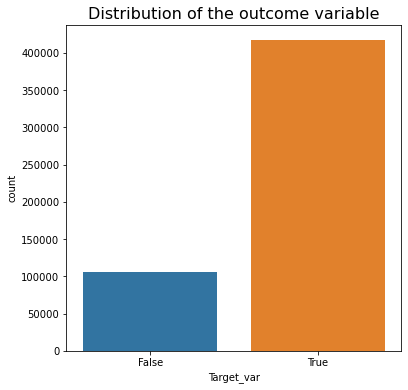

In [32]:

plt.figure(figsize=(6,6))
plt.title('Distribution of the outcome variable',fontsize=16)
sns.countplot(train_set['Target_var'])
plt.show()

The majority class is P I F, here represented as True.

..

 Calculating the Accuracy,Precision, and Recall of the majority class classifier on test data

In [33]:
#yHatMaj=np.ones(len(merged_Sba))
mod_Test = pd.Series(True, index = test_set.index)


In [34]:
accuracy_score(test_set['Target_var'],mod_Test)

0.8001594914631908

In [35]:
precision_score(test_set['Target_var'], mod_Test)

0.8001594914631908

In [36]:
recall_score(test_set['Target_var'],mod_Test)

1.0

Identifying some variables that, based on my understanding and reading of the source paper are likely to be useful for predicting default. Describing them, my motivation, their distribution, and their relationship to outcomes (in the training data):

### Loans Backed by Real estate:

Describing the estate_backed loans graphically:

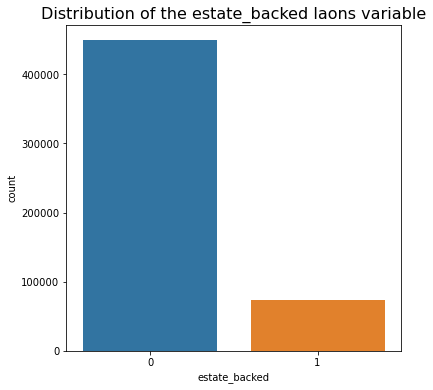

In [37]:

plt.figure(figsize=(6,6))
#plt.SubPlot(1,2,1)
plt.title('Distribution of the estate_backed laons variable',fontsize=16)
sns.countplot(train_set['estate_backed'])
plt.show()
#plt.SubPlot(1,2,1)
#plt.figure(figsize=(6,6))
#plt.title('Distribution of the R/ship between the outcome variable and the estate_backed laons variable',fontsize=16)
#sns.countplot

###  Loan Ratio variable: Describing visually and numerically:

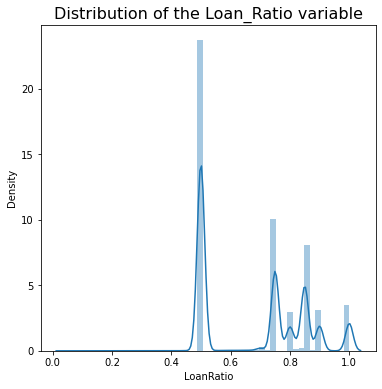

In [38]:
plt.figure(figsize=(6,6))
plt.title('Distribution of the Loan_Ratio variable',fontsize=16)
sns.distplot(train_set['LoanRatio'])
plt.show()

In [39]:
train_set['LoanRatio'].describe()

count    522912.000000
mean          0.680026
std           0.175610
min           0.050000
25%           0.500000
50%           0.750000
75%           0.850000
max           1.000000
Name: LoanRatio, dtype: float64

### NewExist Variable: Whether a business is new or existing

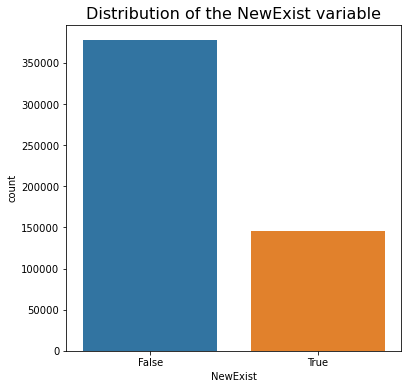

In [40]:
plt.figure(figsize=(6,6))
plt.title('Distribution of the NewExist variable',fontsize=16)
sns.countplot(train_set['NewExist'])
plt.show()

### Loan during Recession:

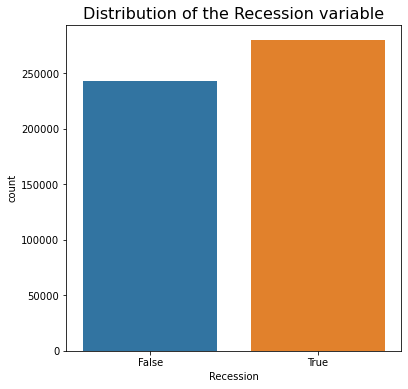

In [41]:
plt.figure(figsize=(6,6))
plt.title('Distribution of the Recession variable',fontsize=16)
sns.countplot(train_set['Recession'])
plt.show()

### UrbanRural variable:

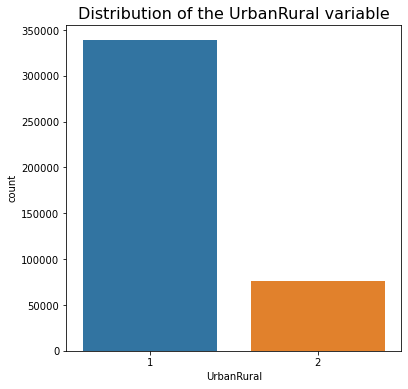

In [42]:
plt.figure(figsize=(6,6))
plt.title('Distribution of the UrbanRural variable',fontsize=16)
sns.countplot(train_set.loc[train_set['UrbanRural'] !=0, "UrbanRural"])
plt.show()

In [43]:
data = [train_set['UrbanRural'].value_counts()[1], train_set['UrbanRural'].value_counts()[1]]
variables = ["Urban", "Rural"]

### GrossApproved

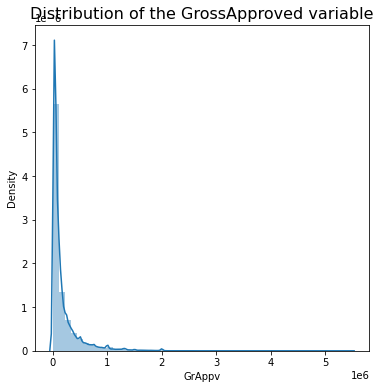

In [44]:
plt.figure(figsize=(6,6))
plt.title('Distribution of the GrossApproved variable',fontsize=16)
sns.distplot(new_Sba['GrAppv'])
plt.show()

In [45]:
new_Sba['GrAppv'].describe()

count    6.972160e+05
mean     1.823464e+05
std      2.900294e+05
min      2.000000e+02
25%      3.000000e+04
50%      7.500000e+04
75%      2.000000e+05
max      5.472000e+06
Name: GrAppv, dtype: float64

### DisbursementGross variable

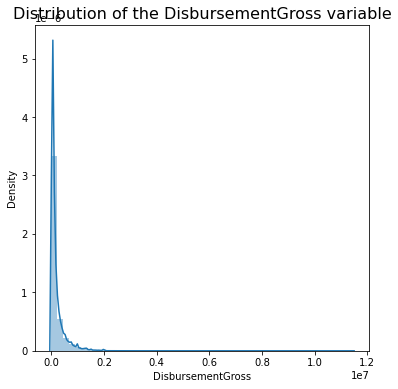

In [46]:
plt.figure(figsize=(6,6))
plt.title('Distribution of the DisbursementGross variable',fontsize=16)
sns.distplot(new_Sba['DisbursementGross'])
plt.show()

In [47]:
new_Sba['DisbursementGross'].describe()

count    6.972160e+05
mean     1.938967e+05
std      2.964580e+05
min      0.000000e+00
25%      3.586725e+04
50%      9.000000e+04
75%      2.152215e+05
max      1.144632e+07
Name: DisbursementGross, dtype: float64

### SBAApproved Variable

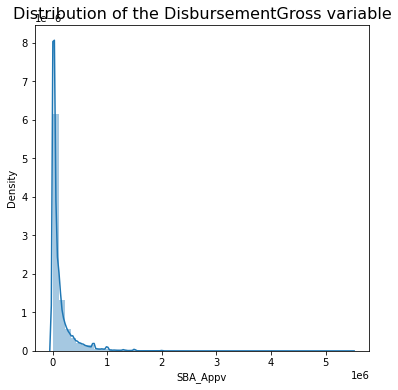

In [48]:
plt.figure(figsize=(6,6))
plt.title('Distribution of the DisbursementGross variable',fontsize=16)
sns.distplot(train_set['SBA_Appv'])
plt.show()

In [49]:
train_set['SBA_Appv'].describe()

count    5.229120e+05
mean     1.398546e+05
std      2.375250e+05
min      2.000000e+02
25%      1.700000e+04
50%      5.000000e+04
75%      1.500000e+05
max      5.472000e+06
Name: SBA_Appv, dtype: float64

### State Variable

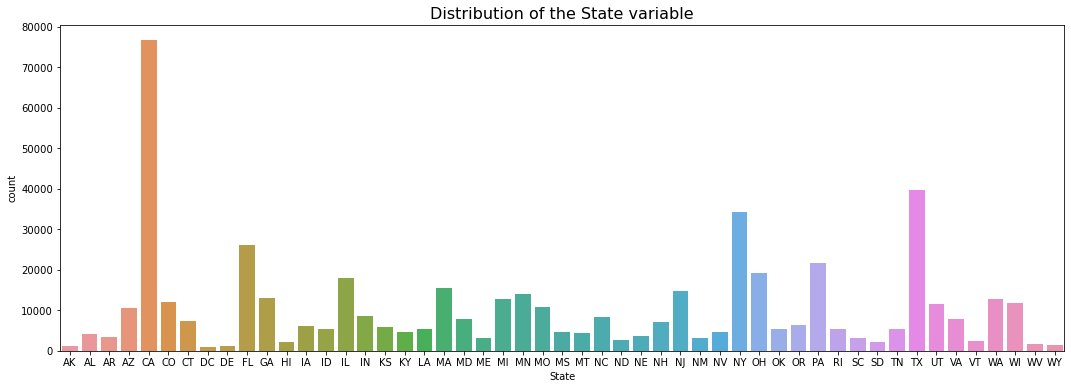

In [50]:
plt.figure(figsize=(18,6))
plt.title('Distribution of the State variable',fontsize=16)
sns.countplot(train_set['State'])
plt.show()

### Variables selected and justifications

The states have different default rates owing to the  great recession and the mineral resources in those states. While some states were affected by the great recession others where not due to the mineral resources they have. This accounts for the difference in the default rates.We selected the state variable because the various states have different economic environment that can affect the target variable.We can actually draw insights from the default rate of various states and see it in the distribution also.

SBA's Guaranteed Portion of Approved Loan:We selected this variable due to its relevance to the outcome variable. Loans that were guaranteed by the SBA tend not to default and a whole lot that were not guaranteed defaulted, as such it we recommended its use in our work.

We selected industries due to the varying rates of defaults it has. While industries in the oil and gas and other lucrative sectors had a lower default rates,  the ones that are on the other hand had a higher rate of default due to the fact that their business are not so promising and hence stand the chance to default on the laon.

Gross disbursement (represented as “DisbursementGross” in the dataset) is another risk indicator identified as a key variable to consider. The reason behind selecting “DisbursementGross” is that the larger the loan size, the more likely the underlying business will be established and expanding (i.e., purchasing assets that have some resale value), thereby increasing the likelihood of paying off the loan. 

NewExist variable is another variable we considered. New businesses are fragile and are likey to default while the existing businesses have some experiences and foundation that will foster their ability to payoff their loan.

Loans Backed by Real Estate is another variable we saw fit to include. Loans backed by real estate are likey not to default because the value of the property can pay off the loan. So, we selected it.


Recession is another variable we selected going by the fact that loans giving during the recession or ones that entered into that period are likely to default.

## Initial Logistic Model

### Extracting train_y and train_x from train_set

In [51]:
train_set1=train_set[train_set['NewExist'].notnull()].copy()

In [52]:
train_x= train_set1[["NewExist","DisbursementGross","Recession",
"LoanRatio","estate_backed","State","Industry"]]
train_y=train_set1["Target_var"]
train_y=np.ravel(train_y)                    

### Extracting test_x and test_y from test_set:

In [53]:
test_set1=test_set[test_set['NewExist'].notnull()].copy()

In [54]:
test_x= test_set1[["NewExist","DisbursementGross","Recession",
"LoanRatio","estate_backed","State","Industry"]]
test_y=test_set1["Target_var"]

In [55]:
test_set1=test_set[test_set['NewExist'].notnull()].copy()

In [56]:
# test_x= test_set1[["NewExist","DisbursementGross","Recession",
# "LoanRatio","estate_backed","State","Industry"]]
# test_y=test_set1["Target_var"]
# test_y=np.ravel(test_y)     
numeric_features = ["DisbursementGross","LoanRatio"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant")), ("scaler", StandardScaler())]
)

categorical_features = ["NewExist","Recession", "estate_backed","Industry","State"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
log_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(penalty='none'))])

Fitting the Logistic model:

In [57]:
#logis_mod=LogisticRegression(penalty='none')
logis_mod=log_clf.fit(train_x,train_y)

### Calculating the Accuracy

In [58]:
logis_acc=logis_mod.predict(train_x)
accuracy_score(train_y,logis_acc)

0.7980761690171018

Doing same thing on the test set:

In [59]:
#logis_mod1=LogisticRegression(penalty='none')
logis_mod1=log_clf.fit(test_x,test_y)

In [60]:
logis_acc1=logis_mod.predict(test_x)
accuracy_score(test_y,logis_acc1)

0.8009054966746811

### Lasso Regression

In [61]:
numeric_features = ["DisbursementGross","LoanRatio"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant")), ("scaler", StandardScaler())]
)

categorical_features = ["NewExist","Recession", "estate_backed","Industry","State"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegressionCV(penalty='l1', cv=2, solver='saga', max_iter=300, n_jobs=-1))]
)

Fitting the model

In [62]:

lasso_mod=clf.fit(train_x,train_y)

### Calculating the Accuracy

In [63]:
lasso_acc=clf.predict(train_x)
accuracy_score(train_y,lasso_acc)

0.7970872839324344

Doing same thing on the test set:

In [64]:
lasso_acc1=clf.predict(test_x)
accuracy_score(test_y,lasso_acc1)

0.8001423087296077

### ElasticNet

In [65]:
clf_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegressionCV(penalty='elasticnet', cv=2, solver='saga', max_iter=500, n_jobs=-1,l1_ratios=np.arange(0,1,0.2)))]
)

Fitting the model

In [66]:
elastic_mod=clf_elastic.fit(train_x,train_y)

### Calculating the Accuracy

In [67]:
elastic_acc=clf_elastic.predict(train_x)
accuracy_score(train_y,elastic_acc)

0.7970853711953269

Doing same thing on the 25% test Data

In [68]:
elastic_acc1=clf_elastic.predict(test_x)
accuracy_score(test_y,elastic_acc1)

0.8001423087296077

## Random Forest


In [69]:
clf_Rforest = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_estimators=100))])

clf_Rforest.fit(train_x,train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DisbursementGross',
                                                   'LoanRatio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['NewExist', 'Recession',
                                                   'estate_backed', 'Industry',
                                                   'State'])])),
                ('classifier', RandomForestClassifier(n_e

### Calculating the Accuracy

In [70]:
Rforest_acc=clf_Rforest.predict(train_x)
accuracy_score(train_y,Rforest_acc)

0.9345977800773129

Doing same thing on the 25% test Data

In [71]:
Rforest_acc1=clf_Rforest.predict(test_x)
accuracy_score(test_y,Rforest_acc1)

0.7667743545897434

### Final Summary and Reflection

In [72]:
def Fpos_r(y_test, y_pred):
    t_pos,f_pos,f_neg,t_neg = confusion_matrix(y_test, y_pred).ravel()
    return f_pos/(f_pos+t_neg)

def Spec_r(y_test, y_pred):
    t_pos,f_pos,f_neg,t_neg = confusion_matrix(y_test, y_pred).ravel()
    return t_neg/(f_pos+t_neg)

def Fneg_r(y_test, y_pred):
    t_pos,f_pos,f_neg,t_neg = confusion_matrix(y_test, y_pred).ravel()
    return f_neg/(t_pos+f_neg)

def cost_r(y_test, y_pred):
    t_pos,f_pos,f_neg,t_neg = confusion_matrix(y_test, y_pred).ravel()
    return (5 * f_neg) + f_pos

In [73]:
no_models = 4

accuracy_ = np.ones(no_models)
precision_ = np.ones(no_models)
recall_ = np.ones(no_models)
falseP = np.ones(no_models)
falseN = np.ones(no_models)
specificity = np.ones(no_models)
cost_ = np.ones(no_models)


models = [lasso_pipe,elastic_pipe,randf_pipe]
models_names = ['lasso Pipeline','Elastic Pipeline','Random Classifier']

for i in range(len(models)):
    pred = models[i].predict(X_test)
    accuracy_[i] = accuracy_score(y_test,pred)
    precision_[i] = precision_score(y_test,pred)
    recall_[i] = recall_score(y_test,pred)
    falseP[i] = fpr(y_test,pred)
    falseN[i] = fnr(y_test,pred)
    specificity[i] = spec(y_test,pred)
    cost_[i] = cost(y_test,pred)




NameError: name 'lasso_pipe' is not defined

In [ ]:
model_metrics = pd.DataFrame({'Model':models_names ,'Accuracy': accuracy_,'Precision': precision_,'Recall': recall_,'Specificity':specificity,'FalsePositives':falseP,'FalseNegatives':falseN,'Costs':cost_})

In [ ]:
temp_df = model_metrics.drop(['Costs'], axis=1)
temp_df = temp_df.melt(id_vars='Model')
# temp_df
plt.figure(figsize=(18,6))
sns.barplot(x = 'variable', y='value', hue='Model', data=temp_df)
plt.show()